## План работы

Для успешного выполнения поставленной задачи необходимо:
- загрузить и исследовать данные:
  - проанализировать пропуски и обработать их (заполнить или удалить)
  - исследовать выбросы и аномальные значения
  - оценить релевантность присутствующих признаков, удалить признаки, которые не являются информативными
- подготовить выборки для обучения и тестирования моделей
- подобрать наилучшую модель машинного обучения:
  - исследовать модели градиентного бустинга (LightGBM) с различными гиперпараметрами
  - исследовать регрессионные модели (линейная регрессия, случаный лес) с различными гиперпараметрами
- проанализировать время обучения рассмотренных моделей, время предсказания и их качество
- протестировать лучшую модель на тестовой выборке

In [1]:
!pip -q install pandas_profiling
!pip -q install category_encoders

In [2]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

## Подготовка данных

Загрузим исходный датасет и исследуем его.

In [3]:
local_path = 'autos.csv'
server_path = '/datasets/autos.csv'

if os.path.exists(local_path):
    data = pd.read_csv(local_path)
else:
    data = pd.read_csv(server_path)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В представленном датасете имеется информация об автомобилях. Представлены следующие данные:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

Проанализируем данные на наличие пропусков, дубликатов и аномальных значений.

### Удаление дубликатов

In [5]:
data.duplicated().sum()

4

В датасете присутствует 4 дубликата. Удалим их.

In [6]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Обработка пропусков

Рассмотрим наличие пропусков в столбцах.

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски присутствуют в следующих столбцах:
- `Vehicle Type` (тип кузова)
- `Gearbox` (тип коробки передач)
- `Model` (модель автомобиля)
- `Fuel Type` (тип топлива)
- `Repaired` (наличие или отсутствие ремонта)

Рассмотрим каждый столбец отдельно.

Тип кузова может быть не указан из-за отсутствия нужного выбора в анкете.
Рассмотрим все имеющиеся значения данного признака.

In [8]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Как мы видим, в датасете уже присутствуют значения `other`. В таком случае, заполним имеющиеся пропуски тем же значением.

In [9]:
data['VehicleType'].fillna(value='other', inplace=True)
data['VehicleType'].isna().sum()

0

Рассмотрим столбец `Gearbox`, в котором приводится информация о типе коробки передач.
Для начала, рассмотрим, какие значения присутствуют в датасете.

In [10]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

В данном случае, заполним отсутствующие значения модой значения той же модели.

In [11]:
grouped_data = data.groupby(
    by=['Brand', 'Model']
)['Gearbox'].apply(lambda x: x.mode().iloc[0])

merged_data = pd.merge(data, grouped_data, left_on=['Brand', 'Model'], right_index=True, how='left')

merged_data['Gearbox_x'].fillna(merged_data['Gearbox_y'], inplace=True)

merged_data.drop(columns=['Gearbox_y'], inplace=True)
merged_data.rename(columns={'Gearbox_x': 'Gearbox'}, inplace=True)

data = merged_data.copy()

In [12]:
data['Gearbox'].isna().sum() / len(data)

0.01165747181578316

По итогам заполнения осталось незаполненными около 1% от всех данных. Удалим эти строки.

In [13]:
data.dropna(subset=['Gearbox'], inplace=True)
data['Gearbox'].isna().sum()

0

Рассмотрим столбец `Model`, в котором приводится информация о модели автомобиля.
Для начала, рассмотрим, какие значения присутствуют в датасете.

In [14]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Как мы видим, в списке всех возможных моделей присутствует вариант `other`. В связи со сложностью заполнения данного столбца, заполним все пропуски данным вариантом.

In [15]:
data['Model'].fillna(value='other', inplace=True)
data['Model'].isna().sum()

0

Рассмотрим значения признака `FuelType`, описывающего вид используемого топлива.

In [16]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

По аналогии с предыдущим признаком, так же заполним его с помощью значения `other`.

In [17]:
data['FuelType'].fillna(value='other', inplace=True)
data['FuelType'].isna().sum()

0

Обработаем пропуски в столбце `Repaired`.

In [18]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Скорее всего, наличие пропусков в данном столбце говорит об отсутствии ремонта у автомобиля, но возможно, что владелец скрывает информацию. Чтобы не смешивать эти автомобили вместе, заполним пропуски отдельной заглушкой.

In [19]:
data['Repaired'].fillna(value='no_info', inplace=True)
data['Repaired'].isna().sum()

0

### Обработка аномальных значений

Среди численных признаков, где возможны выбросы и аномальные значения имеются:
- RegistrationYear — год регистрации автомобиля
- Power — мощность (л. с.)
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- NumberOfPictures — количество фотографий автомобиля
- Price — цена (евро)

Рассмотрим распределение значений перечисленных признаков.

In [20]:
numerical_features = [
    'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'Price'
]

for feature in numerical_features:
    print('-' * 22)
    print(feature)
    print('-' * 22)
    print(data[feature].describe())
    

----------------------
RegistrationYear
----------------------
count    350234.000000
mean       2003.856188
std          68.795645
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64
----------------------
Power
----------------------
count    350234.000000
mean        111.046977
std         189.820035
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64
----------------------
Kilometer
----------------------
count    350234.000000
mean     128511.395239
std       37436.819078
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64
----------------------
RegistrationMonth
----------------------
count    350234.000000
mean          5.762716
std           3.705696
min           0.000000
25%           3.000000

В столбце с информацией о годе регистрации автомобиля имеются аномально высокие значения.
Рассмотрим распределение значений в столбце `DateCreated`, чтобы оценить год выгрузки данных.

In [21]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'].max()

Timestamp('2016-04-07 00:00:00')

Как мы видим, самый поздний год, представленный в колонке DateCreated - 2016. Ограничим датасет этим годом.

In [22]:
data = data[data['RegistrationYear'] <= 2016]

Теперь рассмотрим наименьший год регистрации.
Самый старый автомобиль, когда-либо проданный, был выпущен в 1884 году. Рассмотрим распределение значений года регистрации, ограничив гистограмму этим значением.

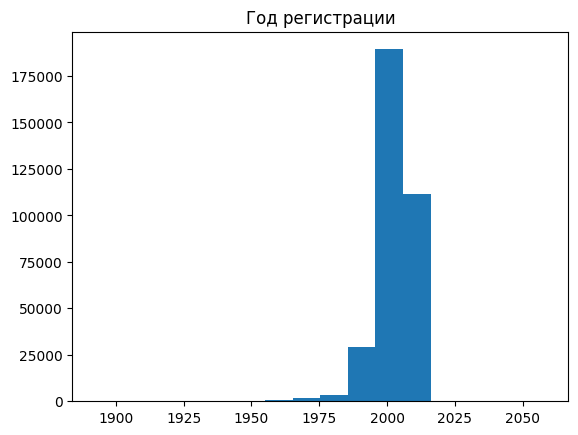

In [23]:
plt.hist(data['RegistrationYear'], bins=100)
plt.xlim(xmin=1884)
plt.title('Год регистрации')
plt.show()

Как мы видим, лишь единичные значения попадают в диапазон менее 1960 года.
Посмотрим на их количество.

In [24]:
data[data['RegistrationYear'] < 1960]['RegistrationYear'].count()

313

Таких значений всего 313. Удалим их.

In [25]:
data=data[data['RegistrationYear'] >= 1960]

В столбце с информацией о мощности двигателя так же имеется много выбросов. Присутствует много значений, близких к нулю, а так же превышающих максимально возможную мощность автомобиля.
Согласно информации из интернета, самым мощным серийным автомобилем является автомобиль с 2012 л.с.
Автомобиль с наименьшей мощностью - 4.2 л.с.

Подсчитаем количество автомобилей с большей и меньшей мощностью.

In [26]:
data[(data['Power'] < 4.2) | (data['Power'] > 2012)]['Power'].count()

33641

Таких строк более 37 тысяч, что составляет 10% от общего количества строк.
Скорее всего, данные значения появились из-за ошибки при вводе данных в анкете.
Рассмотрим отношение стоимости автомобилей к их мощности.

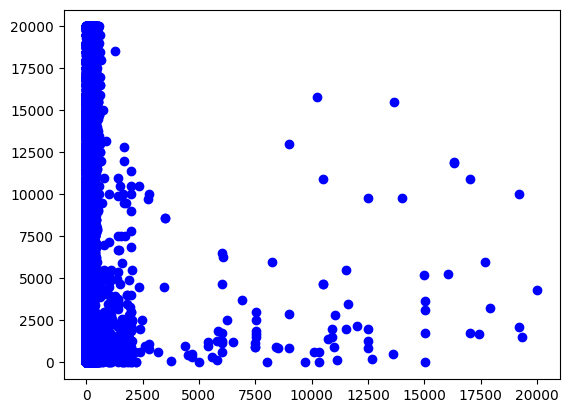

In [27]:
plt.plot(data['Power'], data['Price'], 'bo')
plt.show()

Как видно из графика, автомобили мощностью выше 1000 л.с. не имеют самую большую стоимость.
В связи с этим, можно точно говорить об ошибке, а не о продаже самых мощных автомобилей.
Поэтому, все значения в диапазоне от 1000 до 10000 следует разделить на 10, а от 10000 - на 100.

In [28]:
def power_correction(power):
    if power < 1000:
        return power
    elif power > 1000 and power < 10000:
        return power / 10
    else:
        return power / 100

data['Power'] = data['Power'].apply(power_correction)

Рассмотрим распределение значений данного столбца еще раз.

In [29]:
data['Power'].describe()

count    335808.000000
mean        108.746860
std          63.611217
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max         999.000000
Name: Power, dtype: float64

В столбце остались значения равные нулю. Подсчитаем их количество.

In [30]:
data[data['Power'] == 0]['Power'].count()

33464

Таких значений более 10%. Рассмотрим распределение цены для этих значений.

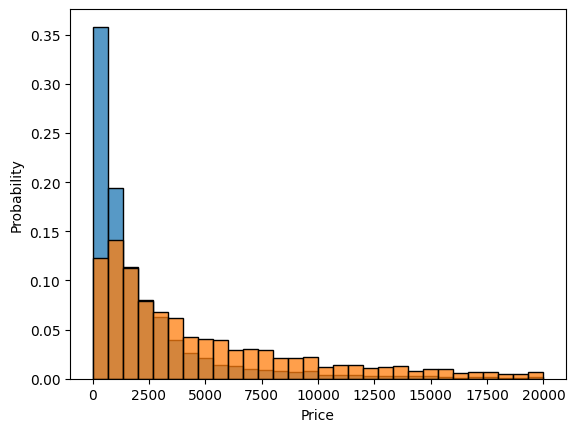

In [31]:
sns.histplot(data[data['Power'] == 0]['Price'], bins=30, stat='probability')
sns.histplot(data[data['Power'] != 0]['Price'], bins=30, stat='probability')
plt.show()

Как мы видим, разброс значений в цене для автомобилей с указанной мощностью 0 л.с. слишком большой и схож с общим распределением цены. Значит, это не значения, близкие к нулю, а просто не указанная мощность.
Поэтому, заполним данные строки значениями моды, как ранее в случае с категориальными признаками.

In [32]:
data['Power'].isna().sum()

0

In [33]:
grouped_data = data.groupby(
    by=['Brand', 'Model']
)['Power'].apply(lambda x: x.mode().iloc[0])

merged_data = pd.merge(data, grouped_data, left_on=['Brand', 'Model'], right_index=True, how='left')

merged_data['Power_x'] = merged_data.apply(lambda row: row['Power_y'] if row['Power_x'] == 0 else row['Power_x'], axis=1)

merged_data.drop(columns=['Power_y'], inplace=True)
merged_data.rename(columns={'Power_x': 'Power'}, inplace=True)

data = merged_data.copy()     

In [34]:
data['Power'].isna().sum()

0

In [35]:
data[data['Power'] == 0]['Power'].count() / len(data)

0.0170752334667429

Около 2% значений осталось 0, для них не удалось подсчитать моду. Удалим эти данные

In [36]:
data.drop(data[data['Power'] == 0].index, inplace=True)

Месяц регистрации не является релевантным, поскольку при оценке автомобиля используется год выпуска, поэтому обрабатывать аномальные значения в этом столбце не нужно, он будет удален.

Рассмотрим распределение значений в столбце с ценами.

In [37]:
data['Price'].describe()

count    330074.000000
mean       4537.029275
std        4555.460627
min           0.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Максимальная цена выглядит правдоподобно, как и 1 и 3 квартили.
рассмотрим гистограмму распределения значений от 0 до 1го квартиля.

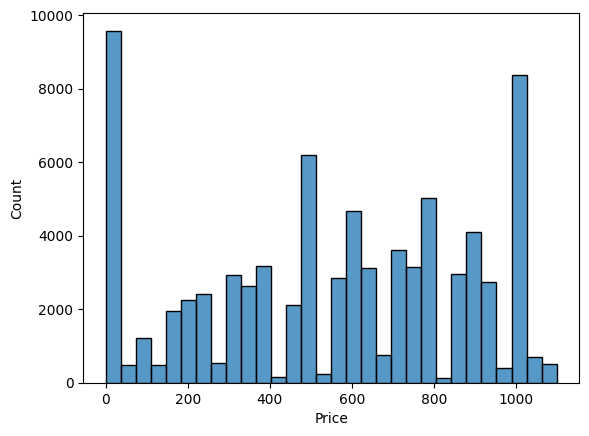

In [38]:
sns.histplot(data[(data['Price'] < 1100)]['Price'], bins=30)
plt.show()

Как мы видим, присутствует большое количество очень маленьких значений. Вряд ли в продаже есть автомобили стоимостью менее 100 евро.

In [39]:
data[data['Price'] < 100]['Price'].count() / len(data)

0.03139598999012343

Относительно общего количества строк, значение меньше 100 имеется в 3 процентах случаев. В связи с этим, выглядит разумным удалить эти строки.

In [40]:
data = data[data['Price'] >= 100]

### Удаление нерелевантных признаков

Как уже говорилось выше, месяц регистрации не является релевантным. Кроме того, нерелевантными признаками для предсказания цены являются:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Так же, стоит отметить, что из-за того, что у всех объявлений отсутствуют фотографии, данный признак так же не является релевантным.
Проверим, есть ли одинаковые названия моделей у разных брендов автомобилей.

In [41]:
result = data.groupby('Model')['Brand'].apply(lambda x: len(set(x)) == 1)

models_with_same_brand = result[result].index.tolist()

print(result.value_counts())

Brand
True     240
False      9
Name: count, dtype: int64


В 9 случаях у одинаковых названий моделей разные бренды, поэтому названия брендов тоже войдут в используемые для обучения и предсказания признаки.

Так же, стоит отметить, что из-за того, что у всех объявлений отсутствуют фотографии, данный признак так же не является релевантным.
Кроме того, можно удалить столбец с маркой автомобиля, поскольку название модели уже вмещает в себя марку.

В связи этим, удалим эти столбцы из датасета.

In [42]:
data = data.drop(
    ['RegistrationMonth', 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], 
    axis=1
)

Еще раз проверим данные на присутствие дубликатов.

In [43]:
data.duplicated().sum()

44472

После предобработки датасета, в нем появились новые дубликаты. Удалим их.

In [44]:
data.drop_duplicates(inplace=True)

## Обучение моделей

### Подготовка выборок

Для начала отделим целевой признак от остальных.

In [45]:
RANDOM_STATE = 12345

In [46]:
target = data['Price']
features = data.drop('Price', axis = 1)

Разделим выборки на тренировочную и тестовую. Подбор гиперпараметров будет осуществялться методом кросс-валидации, поэтому валидационная выборка не понадобится.

In [47]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

Для обучения классических моделей необходимо закодировать категориальные признаки.
Для признака `Model` OHE  создаст большое количество новых столбцов, что сильно увеличит размер матрицы.
В связи с этим, восопльзуемся методом Leave-one-out Encoder. Несмотря на то, что в данном методе кодирование осуществляется с помощью целевого признака, отбрасывание части выборки при обучении данного кодирования позволяет избежать утечки данных.
Остальные признаки закодируем, воспользовавшись OHE.

In [48]:
features_train.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [49]:
encoder = LeaveOneOutEncoder(
    cols=[
        'VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'Repaired'
    ]
)
encoder.fit(features_train, target_train)

features_train_encoded = encoder.transform(features_train)
features_test_encoded= encoder.transform(features_test)

### Модель случайного леса

Обучим модель случайного леса и методом кросс-валидации подберем оптимальные гиперпараметры.

In [50]:
random_forest_model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)

random_forest_params = {
    'n_estimators' : range(100, 201, 50),
    'max_depth' : range(2, 10, 2),
    'min_samples_split' : range(2, 10, 2),
    'min_samples_leaf' : range(2, 100, 10)
}

search_forest_cv = RandomizedSearchCV(
    random_forest_model,
    random_forest_params,
    n_iter=4, 
    verbose=2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

In [51]:
random_forest_search = search_forest_cv.fit(
    features_train_encoded,
    target_train
)

print(f'Лучший результат модели случайного леса: \n{(abs(random_forest_search.best_score_))}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучший результат модели случайного леса: 
1990.4125950547327


Лучшая модель случайного леса, подобранная с помощью Randomized Search дала результат метрики RMSE ниже, чем пороговое значение.

In [52]:
random_forest_model = random_forest_search.best_estimator_

### Модель Light GBM

Для модели градиентного бустинга LightGBM кодирование категориальных признаков не нужно. Поэтому, в данном случае мы воспользуемся оригинальными значениями из датасета.

In [53]:
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'Brand', 'FuelType', 'Repaired']
for col in categorical_columns:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

In [54]:
lgb_params = {
    'num_leaves' : range(10,100,10),
    'max_depth' : range(7,15,1),
    'n_estimators' : range(100,1000,100),
}

lgb_model = lgb.LGBMRegressor(
    objective='regression',
    random_state=RANDOM_STATE
)

search_lgb_cv = RandomizedSearchCV(
    lgb_model,
    lgb_params,
    n_iter=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [55]:
search_lgb_cv.fit(features_train, target_train)

print(f'Лучший результат модели Light GBM: \n{math.sqrt(abs(search_lgb_cv.best_score_))}')

Лучший результат модели Light GBM: 
1579.9150703748717


Результат Light GBM гораздо лучше, чем у модели случайного леса.

In [56]:
lgb_model = search_lgb_cv.best_estimator_

## Анализ моделей

Сравним время обучения и предсказания двух моделей, а так же их результат на тестовой выборке.

In [57]:
random_forest_fit_time = random_forest_search.cv_results_['mean_fit_time'][random_forest_search.best_index_]
random_forest_score_time = random_forest_search.cv_results_['mean_score_time'][random_forest_search.best_index_]

print(f'Время обучения для оптимальной модели случайного леса:\n{random_forest_fit_time}')
print(f'Время предсказания для оптимальной модели случайного леса:\n{random_forest_score_time}')

Время обучения для оптимальной модели случайного леса:
21.103264379501343
Время предсказания для оптимальной модели случайного леса:
0.21228370666503907


In [58]:
lgb_fit_time = search_lgb_cv.cv_results_['mean_fit_time'][search_lgb_cv.best_index_]
lgb_score_time = search_lgb_cv.cv_results_['mean_score_time'][search_lgb_cv.best_index_]

print(f'Время обучения для оптимальной модели Light GBM:\n{lgb_fit_time}')
print(f'Время предсказания для оптимальной модели Light GBM:\n{lgb_score_time}')

Время обучения для оптимальной модели Light GBM:
4.3881187915802
Время предсказания для оптимальной модели Light GBM:
2.2384827613830565


In [59]:
lgb_model_predictions = lgb_model.predict(features_test)

In [60]:
rmse_lgb = mean_squared_error(
    target_test,
    lgb_model_predictions,
    squared=False
)
print(f'Результат модели light GBM на тестовой выборке: {rmse_lgb}')

Результат модели light GBM на тестовой выборке: 1542.2508074189168


# Вывод 

Таким образом, несмотря на то, что модель Light GBM предсказывает на несколько секунду дольше, она дает гораздо более точный результат, а обучается быстрее. Кроме того, нет необходимости обрабатывать категориальные признаки, которых большое количество.